# Project : FloodNet Image Segmentation for disaster Resilience

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the dataset path
path = '/kaggle/input/floodnet/FloodNet'

In [ ]:
import os
import pandas as pd
from PIL import Image # Import the Pillow library
from IPython.display import display
from tqdm import tqdm # Import tqdm for progress bars
import torchvision.transforms as transforms # Import transforms from torchvision

In [ ]:
import json
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import os # Ensure os is imported

# Define image transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Holds processed data
dataset = []

# Folder info
root_dir = path
splits = ["train", "test", "validation"]

for split in splits:
    img_dir = os.path.join(root_dir, split, "img")
    ann_dir = os.path.join(root_dir, split, "ann")

    if os.path.exists(img_dir):
        # Iterate through image files with a progress bar
        for filename in tqdm(os.listdir(img_dir), desc=f"Processing {split}"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(img_dir, filename)
                # Annotation filename is usually the same as image filename + .json
                ann_path = os.path.join(ann_dir, filename + ".json")

                try:
                    # Load image and get original dimensions
                    image = Image.open(img_path).convert("RGB")
                    original_width, original_height = image.size

                    # Apply image transform (resizing happens here)
                    image = image_transform(image)

                    # Load annotation
                    label_data = []
                    if os.path.exists(ann_path):
                        try:
                            with open(ann_path, 'r') as f:
                                ann = json.load(f)

                            if "objects" in ann and isinstance(ann["objects"], list):
                                for obj in ann["objects"]:
                                    label = obj.get("classTitle", "unknown")
                                    points = obj.get("points", {}).get("exterior", [])

                                    scaled_points = []
                                    normalized_points = []

                                    for x, y in points:
                                        # Scaling to resized image (224x224)
                                        width_scale = 224 / original_width
                                        height_scale = 224 / original_height
                                        scaled_x = int(x * width_scale)
                                        scaled_y = int(y * height_scale)
                                        scaled_points.append([scaled_x, scaled_y])

                                        # Normalizing relative to original image size (0–1)
                                        norm_x = x / original_width
                                        norm_y = y / original_height
                                        normalized_points.append([norm_x, norm_y])

                                    # Store both scaled and normalized points
                                    label_data.append({
                                        "label": label,
                                        "points_scaled": scaled_points,
                                        "points_normalized": normalized_points
                                    })

                            else:
                                print(f"Warning: 'objects' key not found or not a list in {ann_path}")
                                label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}]

                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {ann_path}: {e}")
                            label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}]
                        except Exception as e:
                            print(f"Error loading annotation from {ann_path}: {e}")
                            label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}]
                    else:
                        label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}]

                    # Append the image (as tensor) and its annotation data to the dataset
                    dataset.append((image, label_data))

                except Exception as e:
                    print(f"Error processing image {filename} or associated data: {e}")

Processing validation: 100%|██████████| 450/450 [02:32<00:00,  2.96it/s]


In [ ]:
# You can still run your check for annotated vs unlabeled images after this
annotated = 0
unlabeled = 0

for image, annotations in dataset:
    is_annotated = any(item.get('label') != 'unlabeled' for item in annotations)
    if is_annotated:
        annotated += 1
    else:
        unlabeled += 1

print(f"Annotated images: {annotated}")
print(f"Unlabeled images: {unlabeled}")
print(f"Total items in dataset: {len(dataset)}")

Annotated images: 398
Unlabeled images: 1945
Total items in dataset: 2343


In [ ]:
# Debugging prints for the dataset
for i in range(min(5, len(dataset))):
    print(f"Item {i}: Image shape - {dataset[i][0].shape}, Annotations - {dataset[i][1]}")

Item 0: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 1: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 2: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 3: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 4: Image shape - torch.Size([3, 224, 224]), Annotations - []


In [ ]:
for i in range(min(5, len(dataset))):
    img, anns = dataset[i]
    print(f"Item {i}: Image shape - {img.shape}")
    for ann in anns:
        print(f"  - Label: {ann['label']}, Scaled Points: {ann['points_scaled']}")

Item 0: Image shape - torch.Size([3, 224, 224])
Item 1: Image shape - torch.Size([3, 224, 224])
Item 2: Image shape - torch.Size([3, 224, 224])
Item 3: Image shape - torch.Size([3, 224, 224])
Item 4: Image shape - torch.Size([3, 224, 224])


Visualizing Sample 1 with 0 annotations:


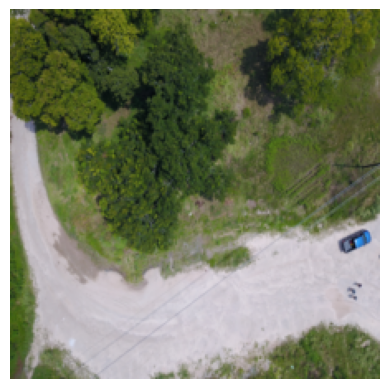

Visualizing Sample 2 with 0 annotations:


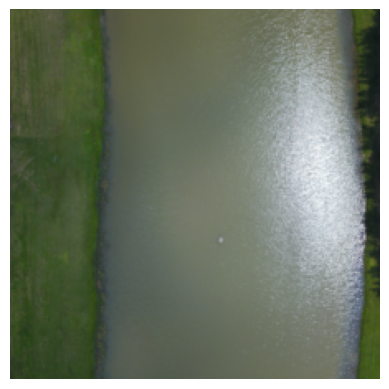

Visualizing Sample 3 with 0 annotations:


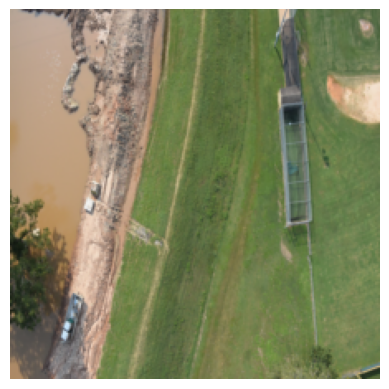

Visualizing Sample 4 with 0 annotations:


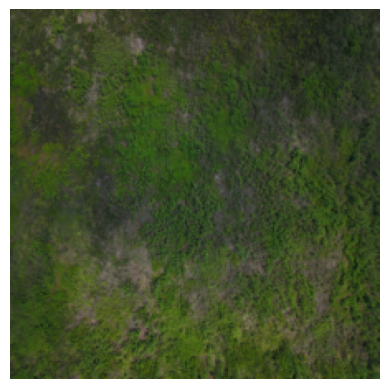

Visualizing Sample 5 with 0 annotations:


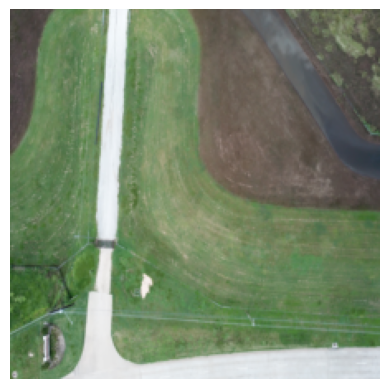

In [ ]:
import matplotlib.patches as patches
import torch

# Function to visualize an image with annotations
def visualize_sample(image_tensor, annotations):
    # Denormalize the image
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean
    image_np = image_tensor.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    for ann in annotations:
        label = ann.get('label', 'unlabeled')
        points = ann.get('points_scaled', [])

        if points:
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]

            if x_coords and y_coords:
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)

                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min - 5, label, color='red', fontsize=10)

    plt.axis('off')
    plt.show()

# Visualize the first few samples
num_samples_to_visualize = 5
for i in range(min(num_samples_to_visualize, len(dataset))):
    image, annotations = dataset[i]
    print(f"Visualizing Sample {i+1} with {len(annotations)} annotations:")
    visualize_sample(image, annotations)


# Model EDA


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import matplotlib.patches as patches
from collections import Counter

# --- EDA: Image Dimensions ---
print("\n=== Image Dimensions Analysis ===")
image_shapes = [img.shape for img, _ in dataset]
unique_shapes = set(image_shapes)
print(f"Unique image shapes in the dataset: {unique_shapes}")
if len(unique_shapes) == 1:
    print(f"All images have the same dimensions: {list(unique_shapes)[0]}")
else:
    print("Images have varying dimensions. This might indicate an issue with the transformation.")




=== Image Dimensions Analysis ===
Unique image shapes in the dataset: {torch.Size([3, 224, 224])}
All images have the same dimensions: torch.Size([3, 224, 224])


In [ ]:
# --- EDA: Label Distribution ---
print("\n=== Label Distribution Analysis ===")
# Count annotated vs unlabeled images
annotated = 0
unlabeled = 0
all_labels = []

for image, annotations in dataset:
    is_annotated = any(item.get('label') != 'unlabeled' for item in annotations)
    if is_annotated:
        annotated += 1
        # Collect all labels for this image
        labels = [item.get('label') for item in annotations if item.get('label') != 'unlabeled']
        all_labels.extend(labels)
    else:
        unlabeled += 1

print(f"Annotated images: {annotated}")
print(f"Unlabeled images: {unlabeled}")
print(f"Total items in dataset: {len(dataset)}")



=== Label Distribution Analysis ===
Annotated images: 398
Unlabeled images: 1945
Total items in dataset: 2343



Label Distribution:
Label 'road non-flooded': 194 occurrences
Label 'vehicle': 126 occurrences
Label 'grass': 368 occurrences
Label 'building non-flooded': 141 occurrences
Label 'water': 187 occurrences
Label 'tree': 311 occurrences
Label 'background': 29 occurrences
Label 'pool': 88 occurrences
Label 'building flooded': 36 occurrences
Label 'road flooded': 37 occurrences


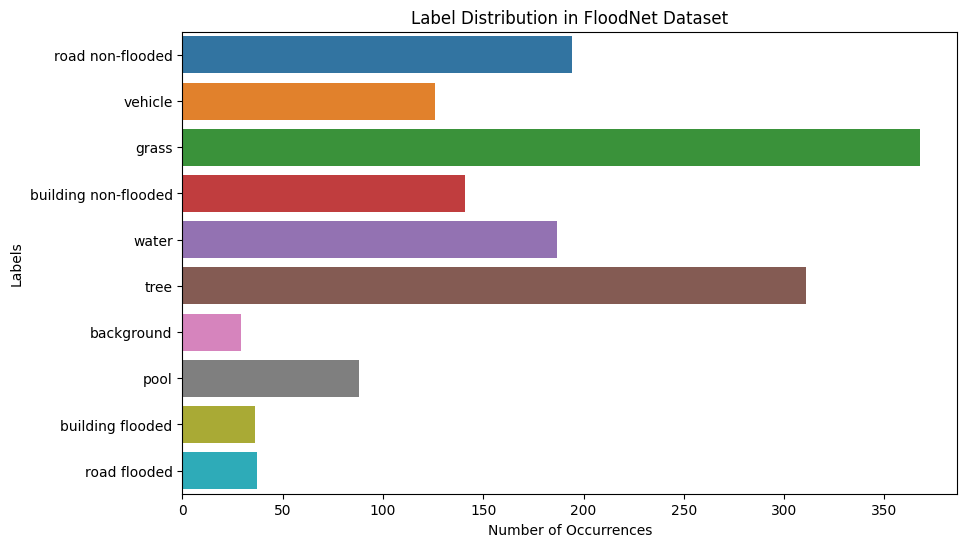

In [ ]:
# Analyze the distribution of labels
label_counts = Counter(all_labels)
print("\nLabel Distribution:")
for label, count in label_counts.items():
    print(f"Label '{label}': {count} occurrences")

# Visualize label distribution using a bar chart
if label_counts:
    # Convert label counts to a pandas DataFrame
    label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).reset_index()
    label_df = label_df.rename(columns={'index': 'label'})

    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='label', data=label_df)
    plt.title("Label Distribution in FloodNet Dataset")
    plt.xlabel("Number of Occurrences")
    plt.ylabel("Labels")
    plt.show()
else:
    print("No labels found to plot.")


=== Sample Visualizations ===
Visualizing Sample 1 with 0 annotations:


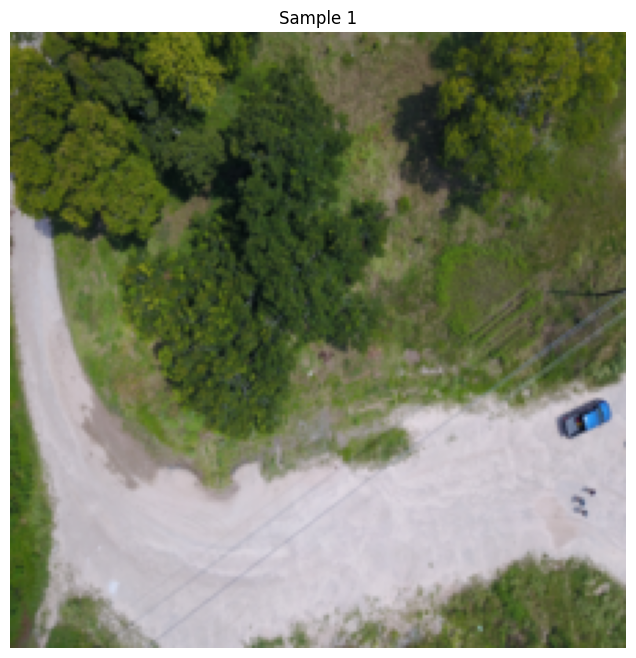

Visualizing Sample 2 with 0 annotations:


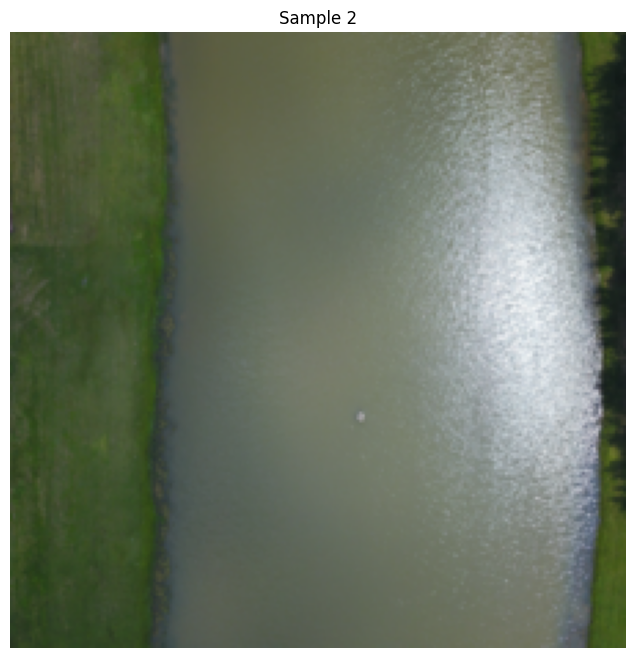

Visualizing Sample 3 with 0 annotations:


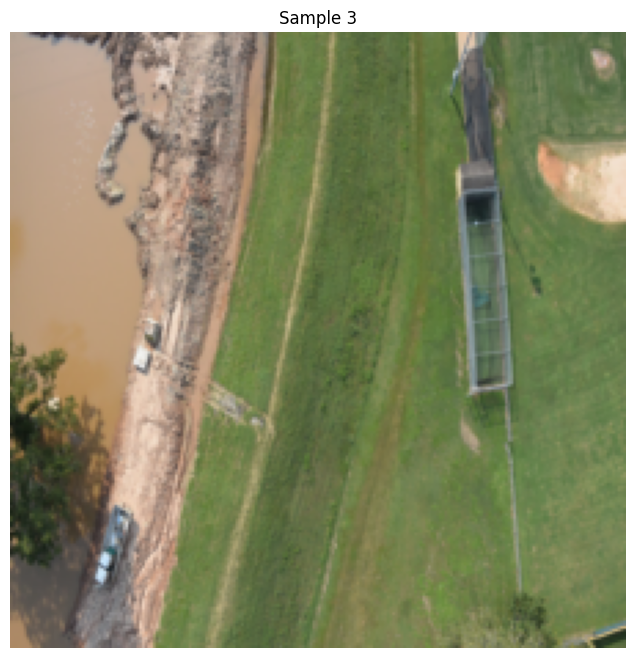

Visualizing Sample 4 with 0 annotations:


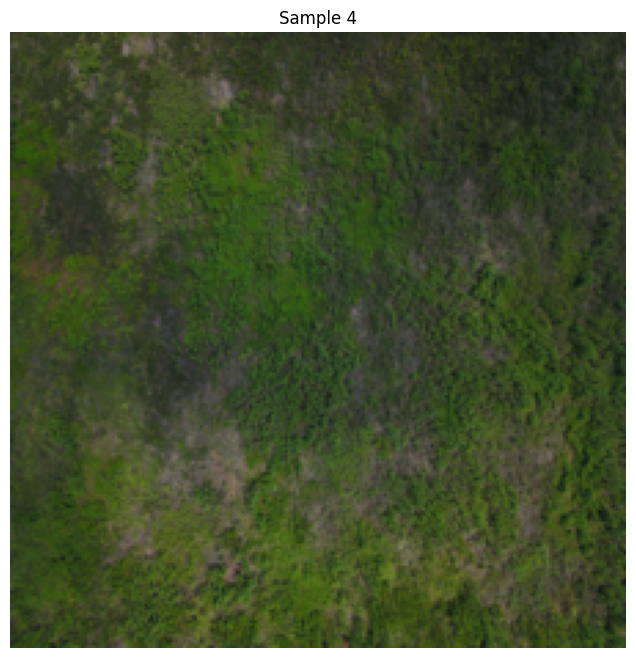

Visualizing Sample 5 with 0 annotations:


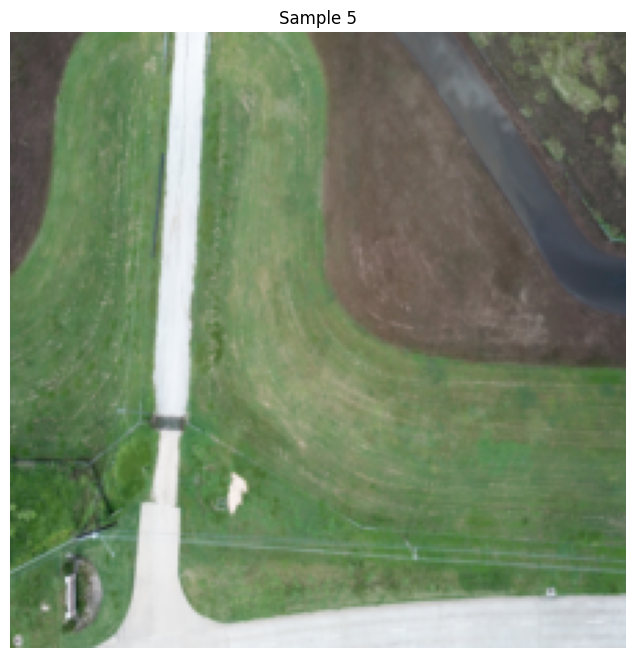

In [ ]:
# --- EDA: Sample Visualizations ---
print("\n=== Sample Visualizations ===")
# Function to visualize an image with annotations
def visualize_sample(image_tensor, annotations, idx):
    # Denormalize the image
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean
    image_np = image_tensor.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    for ann in annotations:
        label = ann.get('label', 'unlabeled')
        points = ann.get('points_scaled', [])

        if points:
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]

            if x_coords and y_coords:
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)

                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_min, y_min - 5, label, color='red', fontsize=10)

    plt.title(f"Sample {idx + 1}")
    plt.axis('off')
    plt.show()

# Visualize the first few samples with annotations
num_samples_to_visualize = 5
for i in range(min(num_samples_to_visualize, len(dataset))):
    image, annotations = dataset[i]
    print(f"Visualizing Sample {i + 1} with {len(annotations)} annotations:")
    visualize_sample(image, annotations, i)